In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU
from sklearn.metrics import mean_absolute_error
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


In [2]:
tf.random.set_seed(42)
encoder_lenth = 300

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print("GPU is available and will be used.")
else:
    print("GPU not available, using CPU.")
    

GPU is available and will be used.


In [4]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
# file_path = 'NVDA-5y.csv'
# file_path = 'AAPL-5y.csv'
file_path = 'TSLA-5y.csv'
drop_lenth = 176
data = pd.read_csv(file_path)
data = data.head(len(data) - drop_lenth)
data.index = range(len(data))
data['Year'] = pd.to_datetime(data['Date']).dt.year.astype(int)
data['Month'] = pd.to_datetime(data['Date']).dt.month.astype(int)
data['Day'] = pd.to_datetime(data['Date']).dt.day.astype(int)

features = ['Open', 'High', 'Low', 'Adj Close', 'Volume','Year','Month','Day']
target = 'Close'


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features + [target]])


def create_dataset(dataset, time_step, forecast_steps):
    X, Y = [], []

    for i in range(len(dataset) - time_step - forecast_steps + 1):
        a = dataset[i:(i + time_step),0:-1] 
        X.append(a)
        Y.append (dataset[(i + time_step):(i + time_step + forecast_steps),-1]) 


    return np.array(X), np.array(Y)

time_step = encoder_lenth
forecast_steps=5
X, y = create_dataset(scaled_data, time_step, forecast_steps)

train_size = len(X) - 2
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:train_size+1], y[train_size:train_size+1]
real_X_test,real_y_test=X[train_size+1:],y[train_size+1:]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
real_X_test=real_X_test.reshape(real_X_test.shape[0], real_X_test.shape[1], real_X_test.shape[2])
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(time_step, len(features))))
model.add(Dropout(0.1))
model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(5))



    
def quantile_loss(quantiles):
    def loss(y_true, y_pred):
        loss_value = 0
        for quantile in quantiles:
            error = y_true - y_pred
            quantile_loss = K.maximum(quantile * error, (quantile - 1) * error)
            loss_value += K.mean(quantile_loss, axis=-1)
        return loss_value / len(quantiles)
    return loss
    
model.compile(optimizer=Adam(learning_rate=0.01, clipnorm=2.0), loss='mse')




early_stopping = EarlyStopping(monitor='val_loss', patience=12, mode='min',restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)


model.fit(X_train, 
          y_train,
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=50,
          callbacks=[early_stopping,
                     reduce_lr]
         )


test_predict = model.predict(X_test)
real_test_predict = model.predict(real_X_test)

Epoch 1/50
7/7 [==============================] - 2s 77ms/step - loss: 0.3483 - val_loss: 0.1220 - lr: 0.0100
Epoch 2/50
7/7 [==============================] - 0s 29ms/step - loss: 0.0449 - val_loss: 0.0129 - lr: 0.0100
Epoch 3/50
7/7 [==============================] - 0s 28ms/step - loss: 0.0164 - val_loss: 0.0077 - lr: 0.0100
Epoch 4/50
7/7 [==============================] - 0s 30ms/step - loss: 0.0122 - val_loss: 0.0067 - lr: 0.0100
Epoch 5/50
7/7 [==============================] - 0s 33ms/step - loss: 0.0078 - val_loss: 0.0040 - lr: 0.0100
Epoch 6/50
7/7 [==============================] - 0s 31ms/step - loss: 0.0066 - val_loss: 0.0024 - lr: 0.0100
Epoch 7/50
7/7 [==============================] - 0s 30ms/step - loss: 0.0057 - val_loss: 0.0017 - lr: 0.0100
Epoch 8/50
7/7 [==============================] - 0s 33ms/step - loss: 0.0053 - val_loss: 0.0104 - lr: 0.0100
Epoch 9/50
7/7 [==============================] - 0s 30ms/step - loss: 0.0066 - val_loss: 0.0031 - lr: 0.0100
Epoch 10/5

In [5]:
y_test= data['Close'][-10:-5].values
y_test
real_y_test=data['Close'][-5:].values

In [6]:

def inverse_transform_predictions(predictions, original_data, scaler, time_step, forecast_steps):
    extended_predictions = np.zeros((predictions.shape[0], original_data.shape[1]))
    for i in range(forecast_steps):
        extended_predictions[:, -1] = predictions[:, i]
        inverse_scaled_data = scaler.inverse_transform(extended_predictions)
        if i == 0:
            inverse_scaled_predictions = inverse_scaled_data[:, -1].reshape(-1, 1)
        else:
            inverse_scaled_predictions = np.hstack((inverse_scaled_predictions, inverse_scaled_data[:, -1].reshape(-1, 1)))
    
    return inverse_scaled_predictions

test_predict_original = inverse_transform_predictions(test_predict, data[features + [target]].values, scaler, time_step, forecast_steps)
real_test_predict_original = inverse_transform_predictions(real_test_predict, data[features + [target]].values, scaler, time_step, forecast_steps)

print("test_predict_original:\n", test_predict_original)
print("test_original:\n", y_test)
print("real_test_predict_original:\n", real_test_predict_original)


test_predict_original:
 [[209.96759919 225.1156507  219.3478701  213.81628634 216.33974639]]
test_original:
 [197.360001 200.839996 205.660004 218.509995 219.960007]
real_test_predict_original:
 [[215.49948969 228.81853762 223.87230202 216.97542501 219.53859728]]


In [7]:
import matplotlib.pyplot as plt
import numpy as np

data1 = data['Close']
last_historical_point = data1.iloc[-6]
forecast_predictions = test_predict_original[0]
forecast_actuals = y_test

test_predict_original_np = [last_historical_point] + list(forecast_predictions)
y_test_np = [last_historical_point] + list(forecast_actuals)

print(test_predict_original_np)
print(y_test_np)

[219.960007, 209.96759918724135, 225.1156506986461, 219.3478700983019, 213.8162863405495, 216.33974639390948]
[219.960007, 197.360001, 200.839996, 205.660004, 218.509995, 219.960007]


Mean Absolute Error: 11.777017649946071
Mean Absolute Percentage Error: 5.379411462227039%
Root Mean Squared Error: 13.933799261218628
Spearman corr: 0.09999999999999999


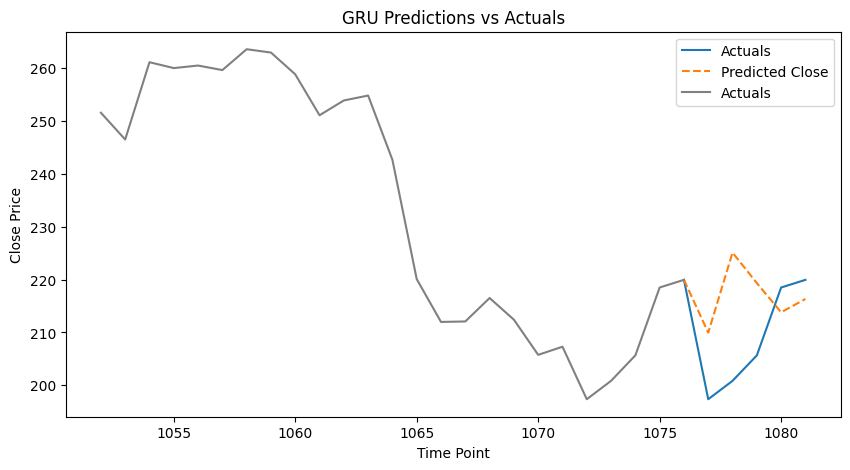

In [8]:

from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

data1 = data['Close']


mae = mean_absolute_error(test_predict_original_np[1:], y_test_np[1:])
print(f'Mean Absolute Error: {mae}')
from sklearn.metrics import mean_absolute_error,mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    


mape = mean_absolute_percentage_error(test_predict_original_np[1:], y_test_np[1:])
print(f'Mean Absolute Percentage Error: {mape}%')


rmse = np.sqrt(mean_squared_error(test_predict_original_np[1:], y_test_np[1:]))
print(f'Root Mean Squared Error: {rmse}')

from scipy.stats import spearmanr
corr, p_value = spearmanr(test_predict_original_np[1:], y_test_np[1:])
print(f"Spearman corr: {corr}")

plt.figure(figsize=(10, 5))
plt.plot(data1.index[-6:], y_test_np, label='Actuals', marker='', linestyle='-')
plt.plot(data1.index[-6:], test_predict_original_np, label='Predicted Close', marker='', linestyle='--')
plt.plot(data1.index[-30:-5], data1[-30:-5], label='Actuals', marker='', linestyle='-', color='grey')

plt.title('GRU Predictions vs Actuals')
plt.xlabel('Time Point')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Mean Absolute Error: 4.811078448376304
Mean Absolute Percentage Error: 2.1777814951702656%
Root Mean Squared Error: 5.181259051394317
Spearman's rho (ρ): 0.7
Spearman's p_value: 0.1881204043741873


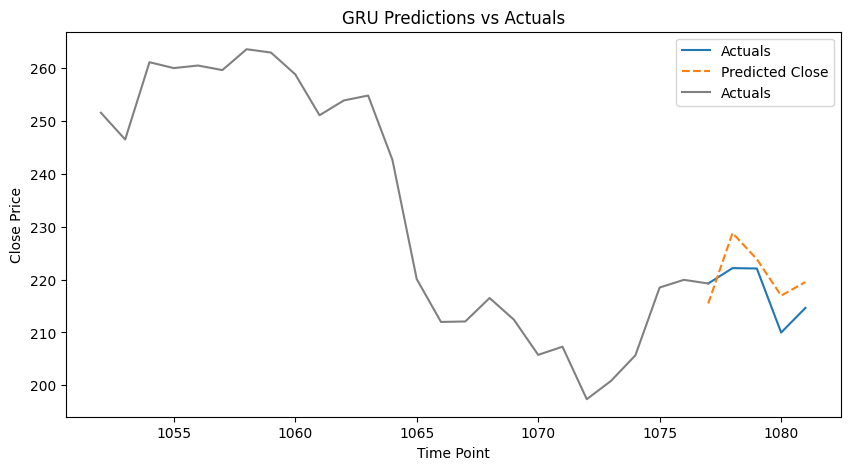

In [9]:
mae = mean_absolute_error(real_test_predict_original[0], real_y_test)
print(f'Mean Absolute Error: {mae}')

mape = mean_absolute_percentage_error(real_test_predict_original[0], real_y_test)
print(f'Mean Absolute Percentage Error: {mape}%')

rmse = np.sqrt(mean_squared_error(real_test_predict_original[0], real_y_test))
print(f'Root Mean Squared Error: {rmse}')

from scipy.stats import spearmanr
corr, p_value = spearmanr(real_test_predict_original[0], real_y_test)
print(f"Spearman's rho (ρ): {corr}")
print(f"Spearman's p_value: {p_value}")

plt.figure(figsize=(10, 5))
plt.plot(data1.index[-5:], real_y_test, label='Actuals', marker='', linestyle='-')
plt.plot(data1.index[-5:], real_test_predict_original[0], label='Predicted Close', marker='', linestyle='--')
plt.plot(data1.index[-30:-4], data1[-30:-4], label='Actuals', marker='', linestyle='-', color='grey')

plt.title('GRU Predictions vs Actuals')
plt.xlabel('Time Point')
plt.ylabel('Close Price')
plt.legend()
plt.show()

